<a href="https://colab.research.google.com/github/arutk1/Beijing_pollution/blob/main/Beijing_pollution_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import folium

import datetime
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression
import glob

This data shows the evolution of six major air pollutants over four years in Beijing. The data was gathered for 12 nationally-controled air quality monitoring sites between 01/03/2013 and 28/02/2017.

The pollutants are: PM2.5, PM10, SO2, NO2, CO, O3.
Pollutants levels as well as temperature, pressure, dew point temperature, precipitation, wind direction and wind speed were measured every hour.




Additional variable information:
PM2.5: PM2.5 concentration (ug/m^3)
PM10: PM10 concentration (ug/m^3)
SO2: SO2 concentration (ug/m^3)
NO2: NO2 concentration (ug/m^3)
CO: CO concentration (ug/m^3)
O3: O3 concentration (ug/m^3)
TEMP: temperature (degree Celsius)
PRES: pressure (hPa)
DEWP: dew point temperature (degree Celsius)
WSPM: wind speed (m/s)


In [ ]:
csv_files = glob.glob('*.{}'.format('csv'))
csv_files

['PRSA_Data_Dingling_20130301-20170228.csv',
 'PRSA_Data_Gucheng_20130301-20170228.csv',
 'PRSA_Data_Huairou_20130301-20170228.csv',
 'PRSA_Data_Shunyi_20130301-20170228.csv',
 'PRSA_Data_Tiantan_20130301-20170228.csv',
 'PRSA_Data_Changping_20130301-20170228.csv',
 'PRSA_Data_Dongsi_20130301-20170228.csv',
 'PRSA_Data_Aotizhongxin_20130301-20170228.csv',
 'PRSA_Data_Nongzhanguan_20130301-20170228.csv',
 'PRSA_Data_Guanyuan_20130301-20170228.csv',
 'PRSA_Data_Wanliu_20130301-20170228.csv',
 'PRSA_Data_Wanshouxigong_20130301-20170228.csv']

In [ ]:
# Concatenation of all files

data = pd.concat([pd.read_csv(f).drop(["No"],axis=1) for f in csv_files ], ignore_index=True)

In [ ]:
# List of dictionaries containing longitudes and latitudes of all 12 air quality monitoring stations of Beijing

sites = [
    {"name": "Dongsi", "location": [39.929829, 116.417948]},
    {"name": "Tiantan", "location": [39.886692, 116.407526]},
    {"name": "Yungang", "location": [39.824778, 116.428358]},
    {"name": "Gucheng", "location": [39.91447, 116.184555]},
    {"name": "Wanliu", "location": [39.987462, 116.292459]},
    {"name": "Fengtaihuayuan", "location": [39.863039, 116.279503]},
    {"name": "Yungang", "location": [39.824778, 116.428358]},
    {"name": "Nongzhanguan", "location": [39.848899, 116.461741]},
    {"name": "Wanshouxigong", "location": [39.87847, 116.352662]},
    {"name": "Aotizhongxin", "location": [39.983437, 116.33338]},
    {"name": "Huairou", "location": [40.357103, 116.628229]},
    {"name": "Miyun", "location": [40.386819, 116.864448]}
]

# Creating a map centered around Beijing using folium library
m = folium.Map(location=[39.9042, 116.4074], zoom_start=10)

# Adding 12 air quality monitoring stations of Beijing to this map
for site in sites:
    folium.Marker(location=site["location"], popup=site["name"],dragable=False).add_to(m)

# Display the map
m

In [ ]:
data.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,4.0,4.0,3.0,NaN,200.0,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,Dingling
1,2013,3,1,1,7.0,7.0,3.0,NaN,200.0,80.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Dingling
2,2013,3,1,2,5.0,5.0,3.0,2.0,200.0,79.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Dingling
3,2013,3,1,3,6.0,6.0,3.0,NaN,200.0,79.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Dingling
4,2013,3,1,4,5.0,5.0,3.0,NaN,200.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Dingling


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 17 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     420768 non-null  int64  
 1   month    420768 non-null  int64  
 2   day      420768 non-null  int64  
 3   hour     420768 non-null  int64  
 4   PM2.5    412029 non-null  float64
 5   PM10     414319 non-null  float64
 6   SO2      411747 non-null  float64
 7   NO2      408652 non-null  float64
 8   CO       400067 non-null  float64
 9   O3       407491 non-null  float64
 10  TEMP     420370 non-null  float64
 11  PRES     420375 non-null  float64
 12  DEWP     420365 non-null  float64
 13  RAIN     420378 non-null  float64
 14  wd       418946 non-null  object 
 15  WSPM     420450 non-null  float64
 16  station  420768 non-null  object 
dtypes: float64(11), int64(4), object(2)
memory usage: 54.6+ MB


In [ ]:
# Checking for missing values
missing_values = data.isnull().sum().sort_values(ascending=False)

In [ ]:
# Calculating the percentage of missing data in each column
missing_percentage = round((missing_values / len(data)) * 100,2)

# Display the missing data statistics
print("Missing values in each column:\n", missing_values)
print("\nPercentage of missing data:\n", missing_percentage)

Missing values in each column:
 CO         20701
O3         13277
NO2        12116
SO2         9021
PM2.5       8739
PM10        6449
wd          1822
DEWP         403
TEMP         398
PRES         393
RAIN         390
WSPM         318
year           0
month          0
hour           0
day            0
station        0
dtype: int64

Percentage of missing data:
 CO         4.92
O3         3.16
NO2        2.88
SO2        2.14
PM2.5      2.08
PM10       1.53
wd         0.43
DEWP       0.10
TEMP       0.09
PRES       0.09
RAIN       0.09
WSPM       0.08
year       0.00
month      0.00
hour       0.00
day        0.00
station    0.00
dtype: float64


PM2.5 and PM10 have the smallest percentage of missing values. Let's analyse the correlation between them and the weather conditions.

In [ ]:
# Remove rows with missing values
data.dropna(subset=['PM2.5'],inplace=True)

In [ ]:
# Verify that missing values have been removed
data.isnull().sum()

year           0
month          0
day            0
hour           0
PM2.5          0
PM10         216
SO2         3698
NO2         6747
CO         15162
O3          8145
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1797
WSPM         317
station        0
dtype: int64

# Data Exploration and Visualisation

In [ ]:
data[['PM2.5','PM10']].describe()

,PM2.5,PM10
count,412029.000000,411813.000000
mean,79.793428,104.672077
std,80.822391,91.723732
min,2.000000,2.000000
25%,20.000000,36.000000
50%,55.000000,82.000000
75%,111.000000,145.000000
max,999.000000,999.000000


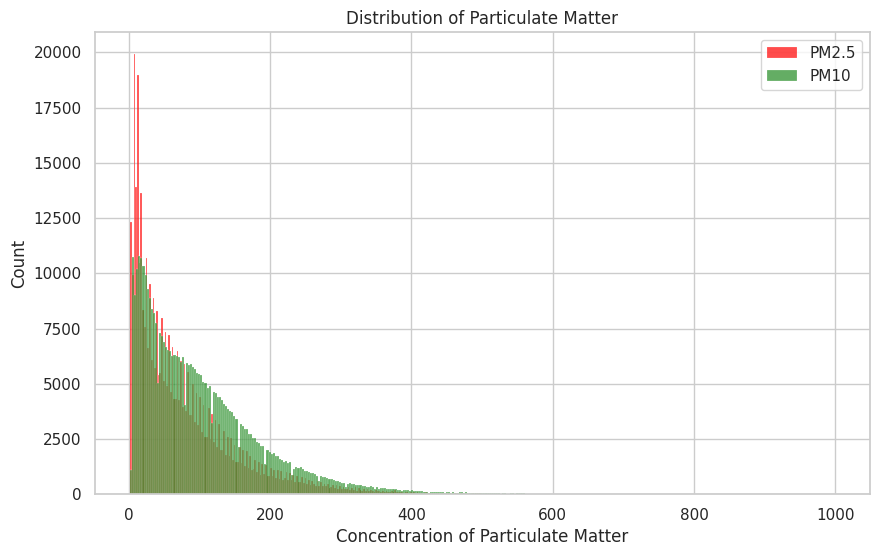

In [ ]:
# Distribution of PM2.5 and PM10 levels

sns.set(style='whitegrid')
plt.figure(figsize=(10,6))
sns.histplot(data['PM2.5'],color='red',kde=False,label='PM2.5',alpha=0.7)
sns.histplot(data['PM10'],color='forestgreen',kde=False,label='PM10',alpha=0.7)
plt.title('Distribution of Particulate Matter')
plt.xlabel('Concentration of Particulate Matter')
plt.legend()
plt.show()

This plot doesn't really give us much utility. By using the Pandas function df.describe(), we already knew that particulate matters levels vary between 2.0 ug/m^3 and 844.0 ug/m^3 for PM2.5 and 999.0 ug/m^3 for PM10. Whereas, when we look on the IQ3 we see way smaller values:
111.0 ug/m^3 for PM2.5 and 145.0 ug/m^3 for PM10.
Let's remove the outliers for better understanding of our data.  

# Using InterQuartile Range to Remove Outliers



In [ ]:
# Removing outliers for PM2.5

Q1 = data['PM2.5'].quantile(0.25)

print("Q1:", Q1)

Q3 = data['PM2.5'].quantile(0.75)

print("Q3:", Q3)
IQR = Q3 - Q1
print("IQR:", IQR)

# Define the bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
print("Lower bound:", lower_bound)
upper_bound = Q3 + 1.5 * IQR
print("Upper bound:", upper_bound)

# Remove outliers
data_no_outliers = data[(data['PM2.5'] >= lower_bound) & (data['PM2.5'] <= upper_bound)]

# Check the shape of the data before and after removal of outliers

print("Original data shape:", data.shape)
print("New data shape without outliers:", data_no_outliers.shape)

Q1: 20.0
Q3: 111.0
IQR: 91.0
Lower bound: -116.5
Upper bound: 247.5
Original data shape: (412029, 17)
New data shape without outliers: (392887, 17)


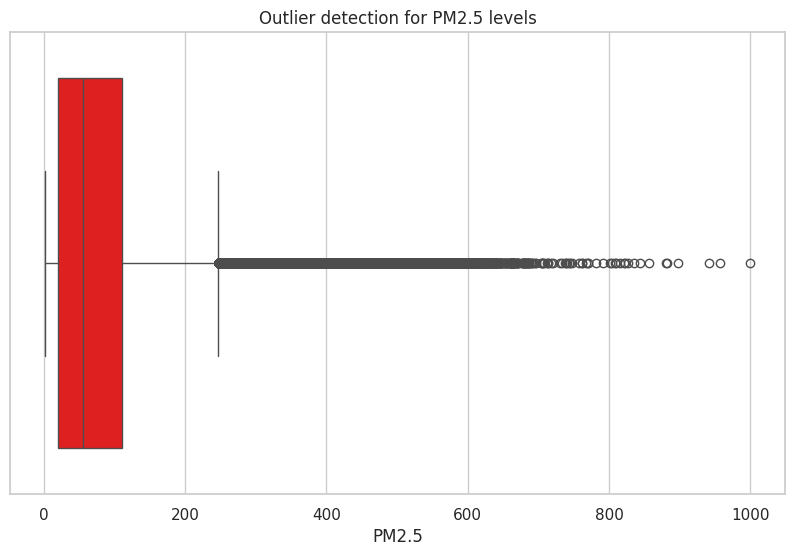

In [ ]:
# Graphical representation of outliers for PM2.5 using box plot

plt.figure(figsize=(10,6))
sns.boxplot(x=data['PM2.5'],color='red')
plt.title('Outlier detection for PM2.5 levels')
plt.xlabel('PM2.5')
plt.show()


Here the calculated lower whisker extends beyond the minimum value in the dataset (in this case it is 2 ug/m^3). Seaborn typically truncates it at the minimum value to avoid showing negative values on the y-axis. So the lower whisker here reaches zero and not beyond.

In [ ]:
# Removing outliers for PM10

Q1_PM10 = data['PM10'].quantile(0.25)

print("Q1:", Q1_PM10)

Q3_PM10 = data['PM10'].quantile(0.75)

print("Q3:", Q3_PM10)
IQR_PM10 = Q3_PM10 - Q1_PM10
print("IQR_PM10:", IQR)

# Define the bounds for the outliers
lower_bound_PM10 = Q1_PM10 - 1.5 * IQR_PM10
print("Lower bound:", lower_bound_PM10)
upper_bound_PM10 = Q3_PM10 + 1.5 * IQR_PM10
print("Upper bound:", upper_bound_PM10)

# Remove outliers
data_no_outliers_PM10 = data[(data['PM10'] >= lower_bound_PM10) & (data['PM10'] <= upper_bound_PM10)]

# Check the shape of the data before and after removal of outliers

print("Original data shape:", data.shape)
print("New data shape without outliers:", data_no_outliers_PM10.shape)

Q1: 36.0
Q3: 145.0
IQR_PM10: 91.0
Lower bound: -127.5
Upper bound: 308.5
Original data shape: (412029, 17)
New data shape without outliers: (397239, 17)


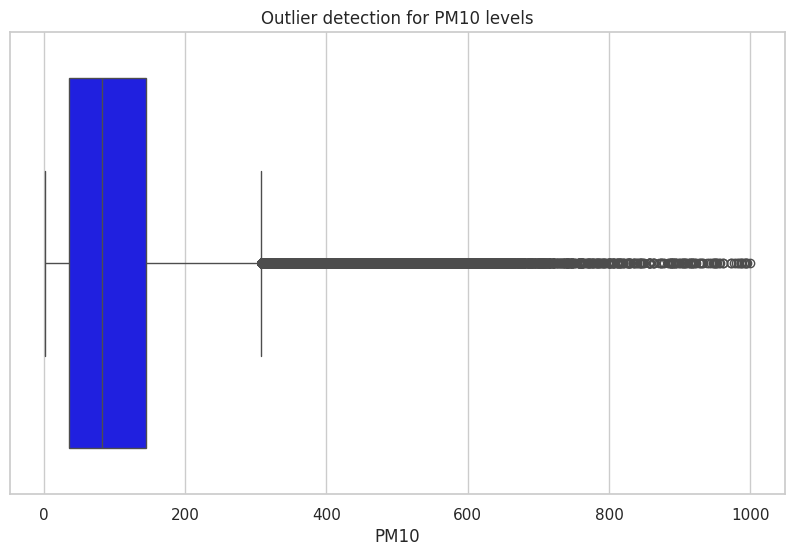

In [ ]:
# Graphical representation of outliers for PM10 using box plot

plt.figure(figsize=(10,6))
sns.boxplot(x=data['PM10'],color='blue')
plt.title('Outlier detection for PM10 levels')
plt.xlabel('PM10')
plt.show()

Here the calculated lower whisker extends beyond the minimum value in the dataset (in this case it is 2 ug/m^3). Seaborn typically truncates it at the minimum value to avoid showing negative values on the y-axis. So the lower whisker here reaches zero and not beyond.

Now we have data for PM2.5 and PM10 without outliers. Let's plot the same distribution of PM2.5 and PM10 levels but using data where the outliers have been removed.

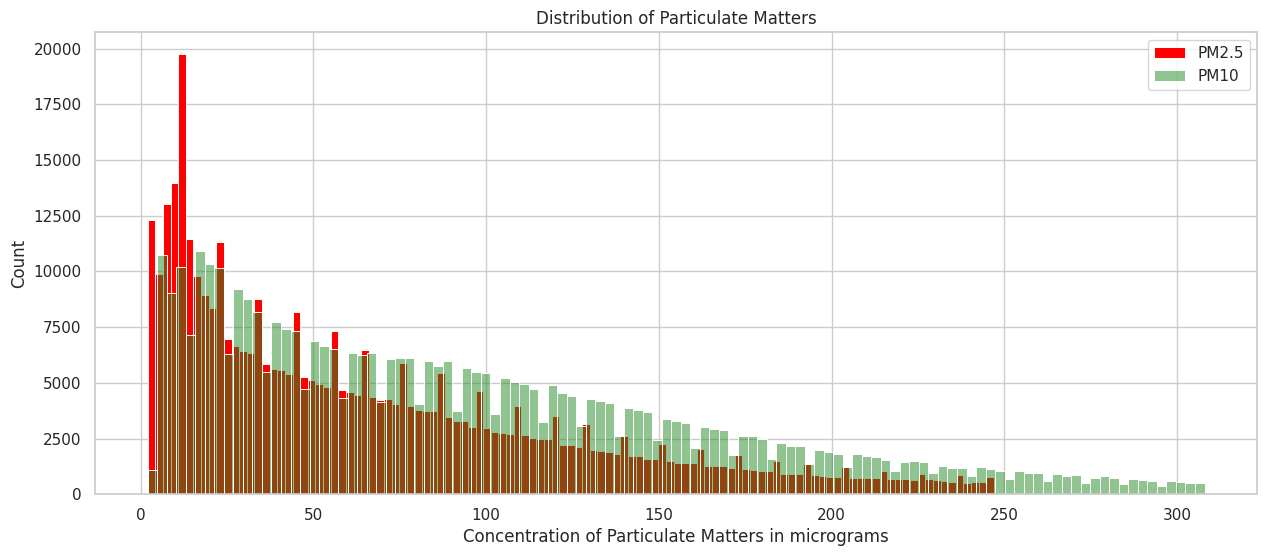

In [ ]:
# Distribution of PM2.5 and PM10 levels after the outliers have been removed

sns.set(style='whitegrid')
plt.figure(figsize=(15,6))
sns.histplot(data_no_outliers['PM2.5'],color='red',kde=False,label='PM2.5',alpha=1.0)
sns.histplot(data_no_outliers_PM10['PM10'],color='forestgreen',kde=False,label='PM10',alpha=0.5)
plt.title('Distribution of Particulate Matters')
plt.xlabel("Concentration of Particulate Matters in micrograms")
plt.legend()
plt.show()

We can see here that the most frequently met concentrations are below 50 ug/m^3 both for PM2.5 and PM10.  

Now let's plot monthly averages for all monitoring stations in Beijing (here I will use the initial data, before outliers have been removed).

In [ ]:
# Transforming list of stations into numerical values
# (which was not really necessary here, but will be useful when plotting heatmap)

data['station'].unique

from sklearn.preprocessing import LabelEncoder

# Label Encoding
label_encoder = LabelEncoder()
data['station_labelencoded'] = label_encoder.fit_transform(data['station'])

data.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,station_labelencoded
0,2013,3,1,0,4.0,4.0,3.0,NaN,200.0,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,Dingling,2
1,2013,3,1,1,7.0,7.0,3.0,NaN,200.0,80.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Dingling,2
2,2013,3,1,2,5.0,5.0,3.0,2.0,200.0,79.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Dingling,2
3,2013,3,1,3,6.0,6.0,3.0,NaN,200.0,79.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Dingling,2
4,2013,3,1,4,5.0,5.0,3.0,NaN,200.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Dingling,2


In [ ]:
# Check the encoding mapping
encoding_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Encoding Mapping:\n")
print(encoding_mapping)


Encoding Mapping:

{'Aotizhongxin': 0, 'Changping': 1, 'Dingling': 2, 'Dongsi': 3, 'Guanyuan': 4, 'Gucheng': 5, 'Huairou': 6, 'Nongzhanguan': 7, 'Shunyi': 8, 'Tiantan': 9, 'Wanliu': 10, 'Wanshouxigong': 11}


In [ ]:
# Another column with non-numerical value is a 'wd' - let's drop it.
# The wind direction shouldn't really influence the levels of PMs.

data.drop('wd',axis=1,inplace=True)


In [ ]:
data.drop('station',axis=1,inplace=True)

In [ ]:
data['month_year'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month'].astype(str))

data['month_year'] = data['month_year'].dt.strftime('%Y-%m')


In [ ]:
data_monthly = data.groupby(data['month_year'],as_index=False).mean().sort_values(by=['year','month'],ascending=True)

data_monthly.head()

,month_year,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,station_labelencoded
0,2013-03,2013.0,3.0,16.044927,11.501633,104.888301,129.053918,38.497117,67.916294,1458.220351,56.521855,5.996611,1012.216034,-6.656649,0.023894,1.883752,5.491949
1,2013-04,2013.0,4.0,15.480527,11.483909,62.139109,95.869048,20.694419,46.336510,902.748038,61.681579,12.341931,1007.835588,-3.206763,0.014401,2.329011,5.502099
2,2013-05,2013.0,5.0,16.221022,11.502787,81.846225,131.449053,25.475486,50.602803,999.010482,86.022269,21.703937,1002.795145,8.283415,0.006005,1.810174,5.511034
3,2013-06,2013.0,6.0,15.574703,11.491568,102.444121,116.338625,13.759517,47.976249,1415.643853,75.699437,23.609917,999.587945,17.448069,0.125582,1.291461,5.509857
4,2013-07,2013.0,7.0,16.098096,11.516174,67.909378,77.188898,7.404900,39.777428,939.776128,80.103142,27.141259,995.383686,20.900000,0.269170,1.310604,5.460119


In [ ]:
data_monthly['PM2.5'].describe()


count     48.000000
mean      79.775855
std       25.472627
min       42.816203
25%       61.018551
50%       72.843205
75%       93.586016
max      150.518426
Name: PM2.5, dtype: float64

In [ ]:
data_monthly['PM10'].describe()

count     48.000000
mean     104.610621
std       27.557666
min       56.350121
25%       82.131542
50%       98.940104
75%      125.979042
max      160.277353
Name: PM10, dtype: float64

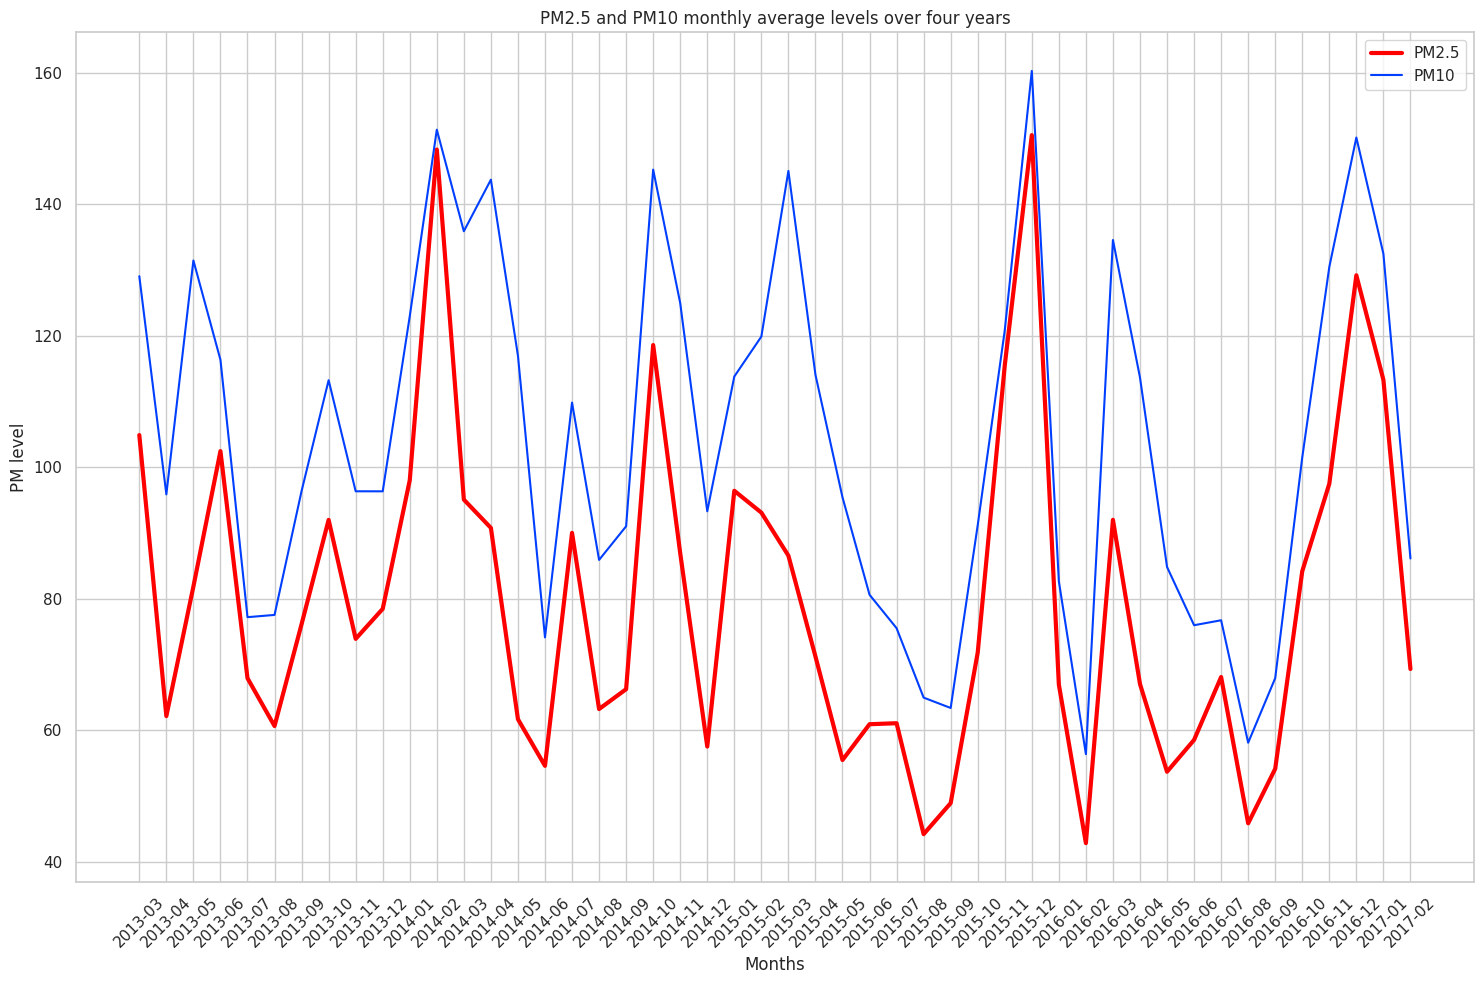

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create a line plot

plt.style.use('seaborn-v0_8-bright')

plt.figure(figsize=(15, 10))
plt.plot(data_monthly['month_year'], data_monthly['PM2.5'],color = 'red', linewidth = 3, label = 'PM2.5')
plt.plot(data_monthly['month_year'], data_monthly['PM10'],label='PM10')
plt.tick_params(axis='x', rotation=45)

# Add labels and title
plt.xlabel('Months')
plt.ylabel('PM level')
plt.title('PM2.5 and PM10 monthly average levels over four years')
plt.legend()

plt.tight_layout()

# Show the plot
plt.show()

plt.savefig('plot_image.png')

Here we can see the monthly averages for 48 months taking into consideration all observations, before removing of the outliers.

# Correlation Heatmap

In [ ]:
data = data_no_outliers.drop(['year','month','hour','day','wd','station'],axis=1)

From now on we will be working on the data without outliers for PM2.5.

In [ ]:
data.corr()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
PM2.5,1.000000,0.812148,0.473631,0.596530,0.724589,-0.085694,-0.031535,-0.057046,0.200128,-0.008430,-0.282421
PM10,0.812148,1.000000,0.433137,0.566890,0.587740,-0.040580,0.003002,-0.092055,0.124051,-0.024033,-0.153443
SO2,0.473631,0.433137,1.000000,0.487376,0.571859,-0.151082,-0.312983,0.223044,-0.271374,-0.041490,-0.097184
NO2,0.596530,0.566890,0.487376,1.000000,0.654944,-0.472041,-0.238339,0.153497,-0.011560,-0.042785,-0.404630
CO,0.724589,0.587740,0.571859,0.654944,1.000000,-0.299090,-0.283258,0.160154,-0.023920,-0.007146,-0.311378
O3,-0.085694,-0.040580,-0.151082,-0.472041,-0.299090,1.000000,0.586712,-0.439899,0.309199,0.021695,0.287233
TEMP,-0.031535,0.003002,-0.312983,-0.238339,-0.283258,0.586712,1.000000,-0.816327,0.825074,0.035846,0.011860
PRES,-0.057046,-0.092055,0.223044,0.153497,0.160154,-0.439899,-0.816327,1.000000,-0.755540,-0.060235,0.080485
DEWP,0.200128,0.124051,-0.271374,-0.011560,-0.023920,0.309199,0.825074,-0.755540,1.000000,0.086496,-0.307191
RAIN,-0.008430,-0.024033,-0.041490,-0.042785,-0.007146,0.021695,0.035846,-0.060235,0.086496,1.000000,0.019666


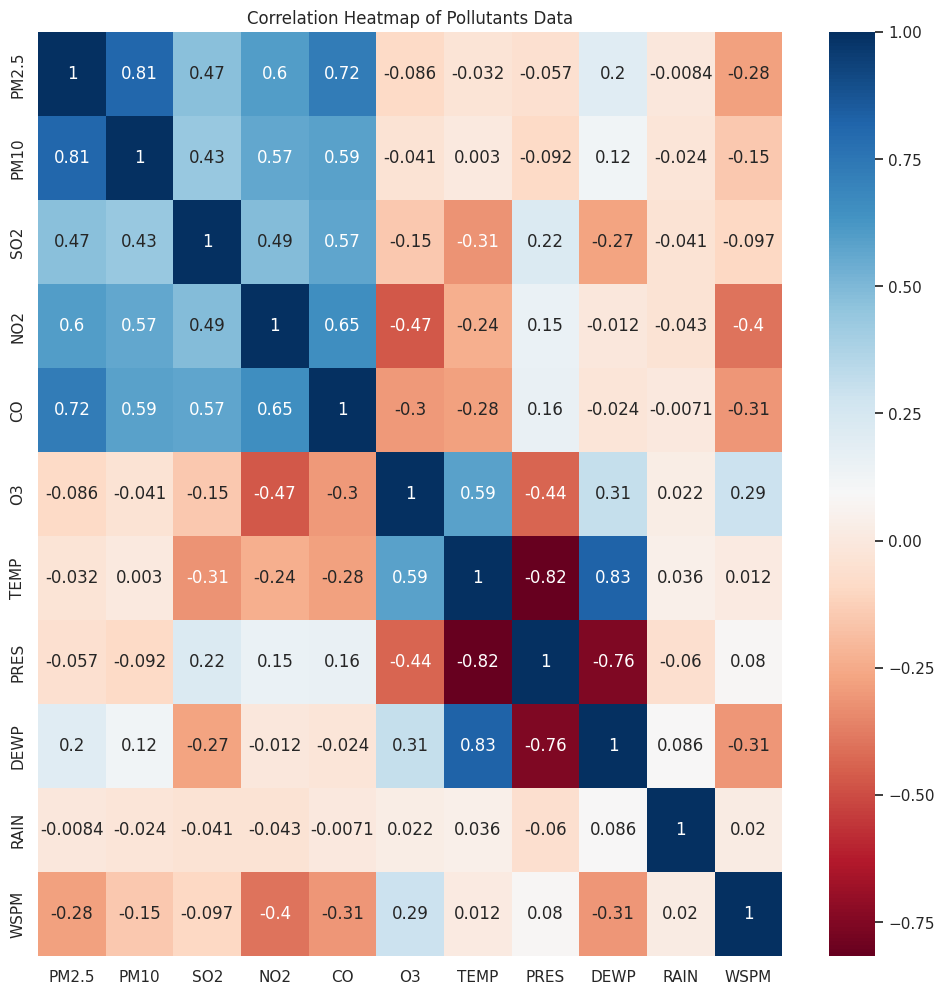

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(data.corr(),annot=True,cmap='RdBu')
plt.title("Correlation Heatmap of Pollutants Data")
plt.show()

By analysing this correlation heatmap we can see that there is no strong correlation between weather conditions like temperature, pressure, dew point temperature, rain and wind speed and the levels of PM2.5 and PM10. Also, there is no correlation between PM2.5 and PM10 levels and the monitoring station.
Although, there is a rather strong positive correlation between two independant variables: dew point temperature and temperature (0,83). One of these variables can be safely dropped. I will drop dew point temperature variable.

In [ ]:
data = data.drop('DEWP',axis=1)

In [ ]:
data.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,RAIN,WSPM
0,4.0,4.0,3.0,NaN,200.0,82.0,-2.3,1020.8,0.0,0.5
1,7.0,7.0,3.0,NaN,200.0,80.0,-2.5,1021.3,0.0,0.7
2,5.0,5.0,3.0,2.0,200.0,79.0,-3.0,1021.3,0.0,0.2
3,6.0,6.0,3.0,NaN,200.0,79.0,-3.6,1021.8,0.0,1.0
4,5.0,5.0,3.0,NaN,200.0,81.0,-3.5,1022.3,0.0,2.1


# Linear Regression for predicting PM2.5 levels

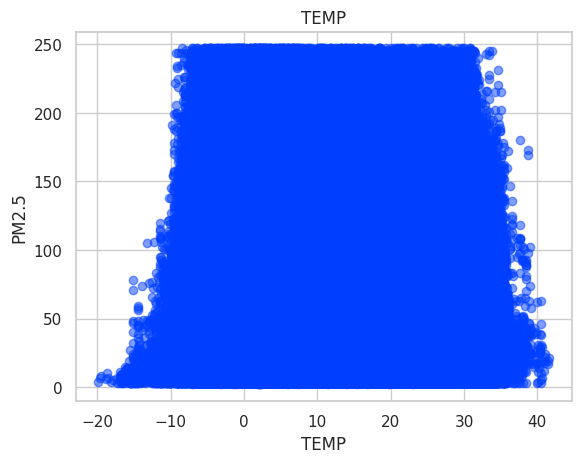

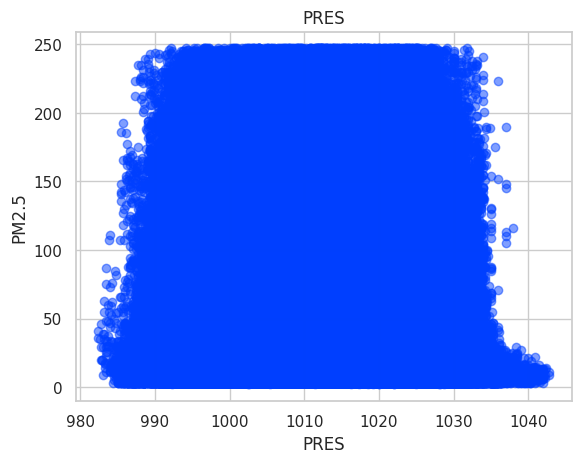

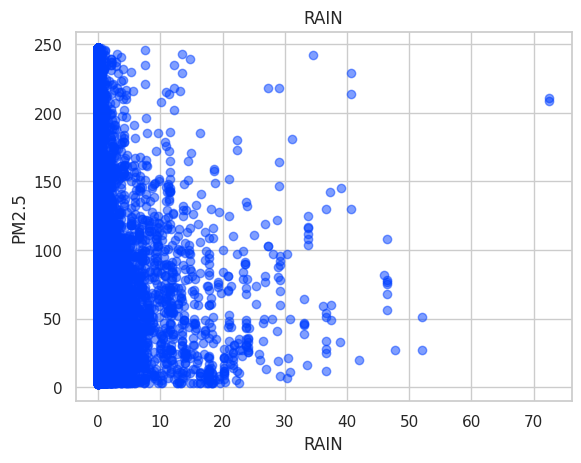

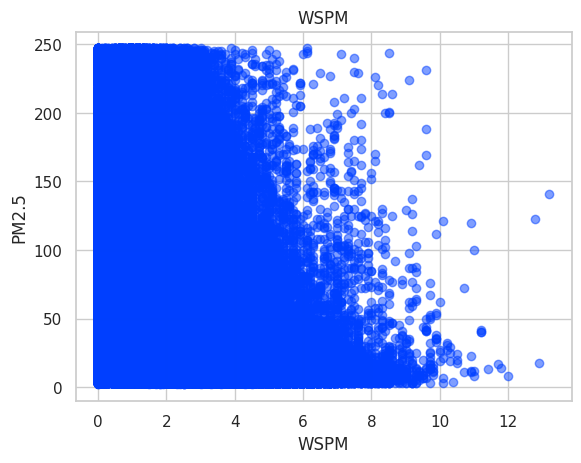

In [ ]:
for label in data.columns[6:10]:
 plt.scatter(data[label],data["PM2.5"],alpha=0.5)
 plt.title(label)
 plt.ylabel("PM2.5")
 plt.xlabel(label)
 plt.show()

These scatter plots give us basically the similar information as heat map - there is not much of a correlation between these weather conditions and levels of PMs. Also, we can see that levels of PM2.5 don't reach beyond the 247.5 micrograms which is the upper bound for PM2.5 level. Nevertheless, we can try to use multiple linear regression model to predict the PMs levels.

# Splitting the dataset into training and test dataset

In [ ]:
# First, we need to get rid of missing values for our independant variables, otherwise the model will throw an error

data.dropna(subset=['TEMP','PRES','RAIN','WSPM','PM2.5'],inplace=True)

In [ ]:
# Defining features (independant variables) and target (dependant variable)

features = ['TEMP','PRES','RAIN','WSPM']
target = ['PM2.5']

X = data[features]
y = data[target]

In [ ]:
# For the sake of simplicity I will not use the validation dataset

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1111)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 313989 samples
Test set size: 78498 samples


# Training

In [ ]:
X_train

,TEMP,PRES,RAIN,WSPM
251342,12.3,1018.7,0.0,1.9
217580,-1.9,1027.4,0.0,5.5
396694,19.9,1006.0,0.0,0.6
8181,-3.4,1019.9,0.0,0.9
403758,-0.3,1025.9,0.0,1.4
...,...,...,...,...
310980,32.2,1005.2,0.0,1.2
398467,24.2,1000.5,0.0,1.6
354204,26.1,994.7,0.0,0.7
404065,12.7,1010.2,0.0,1.7


Here, I will use the library stats models and apply the OLS Regression Model. The stats model gives the possibility to quickly display all the results in the summary with one line of code.

In [ ]:
# I must add a constant to the predictors because OLS from statsmodels doesn't include it by default

import statsmodels.api as sm

X_train_const = sm.add_constant(X_train)
X_train_const


,const,TEMP,PRES,RAIN,WSPM
251342,1.0,12.3,1018.7,0.0,1.9
217580,1.0,-1.9,1027.4,0.0,5.5
396694,1.0,19.9,1006.0,0.0,0.6
8181,1.0,-3.4,1019.9,0.0,0.9
403758,1.0,-0.3,1025.9,0.0,1.4
...,...,...,...,...,...
310980,1.0,32.2,1005.2,0.0,1.2
398467,1.0,24.2,1000.5,0.0,1.6
354204,1.0,26.1,994.7,0.0,0.7
404065,1.0,12.7,1010.2,0.0,1.7


In [ ]:
# Fitting the OLS model

model_fitted = sm.OLS(y_train, X_train_const).fit()

# Displaying OLS Regression Results

print(model_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  PM2.5   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     7835.
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        15:36:26   Log-Likelihood:            -1.7062e+06
No. Observations:              313989   AIC:                         3.412e+06
Df Residuals:                  313984   BIC:                         3.412e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1089.0808     16.783     64.892      0.0

What we can learn from this summary is that all the independant variables are statistically significant because P values for all of them are smaller than 0.05. Here, we are using the method 'Least Squares' which is the underlying approach of minimizing the sum of squared residuals.

R-squared (coefficient of determination) showcases what is the goodness of fit of our model. This means that only 9,1% of the outcome can be explained using these independant variables. It explains how good the model is able to fit our data with linear regression line. It means that all the independant variables that we have included are able to explain 9,1% of variation in our response variable. So the result is not good, everything above 0.5 is reasonable. R squared is the best metrics to explain what is the quality of your regression model. So here our model is not good, we should search for another algorithm which will enable making better predictions.

The F-statistics here is very large what explains that all the independant variables jointly are statistically significant.  

The coefficients explain that when we add one additional unit to the TEMP, so the temperature increases one degree then the PM2.5 level decreases 0,88 micrograms/m^3. It is the most easy to see for WSPM - when then WSPM increases one m/s, then the PM2.5 level decreases 12.35 micrograms/m^3 when all the other criteria are constant.

The standard errors are not large, so the assumptions of the linear regression are not violated.

But we can check them just to make sure.

# Prediction / Testing


In [ ]:
# Adding a constant to the test predictors
X_test_const = sm.add_constant(X_test)

# Making predictions on the test set
test_predictions = model_fitted.predict(X_test_const)

In [ ]:
test_predictions

370106    90.336012
110162    84.338266
307512    72.086234
373898    76.708612
290996    80.887860
            ...    
214571    71.130575
32845     65.404213
222488    70.454459
327706    63.264561
138654    73.256222
Length: 78498, dtype: float64

# Checking OLS assumptions

Assumption 1: Linearity

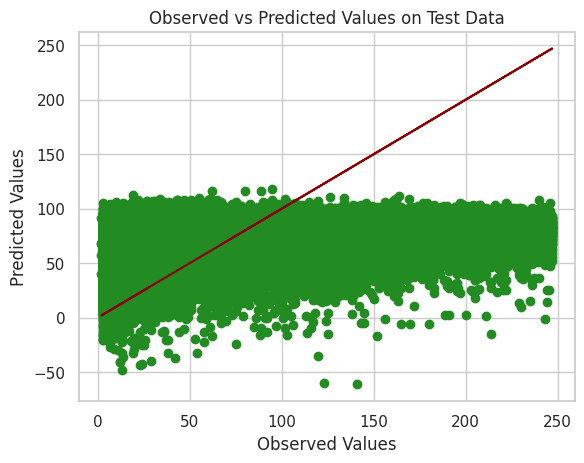

In [ ]:
# Scatter plot for observed vs predicted values on test data

plt.scatter(y_test, test_predictions, color = 'forestgreen')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Observed vs Predicted Values on Test Data')
plt.plot(y_test, y_test, color = 'darkred') # line for perfect prediction (true values)
plt.show()

Here we can see that the first assumption is totally violated and OLS model is not a good model to predict PM2.5 level in Beijing. The red line (which represents a perfect prediction line) and the distribution of the data points suggest there's no linear relationship between the observed and predicted values. When the actual values increase, the predicted values don't increase, which means there is no linear correlation between them. Not to mention that the model predicted negative values which shouldn't happen.

Assumption 2: Random Sample

In [ ]:
# Calculate the mean of the residuals

mean_residuals = np.mean(model_fitted.resid)

print(f"The mean of the residuals is {np.round(mean_residuals,4)}")

The mean of the residuals is -0.0


If the model is well-fitted, the residuals should be randomly scattered around zero without any systematic patterns. The residuals are the difference between the observed values and the predicted values from the model.

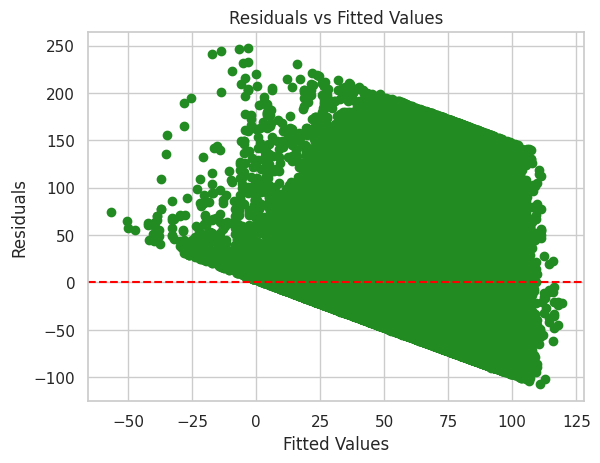

In [ ]:
# Plotting the residuals
plt.scatter(model_fitted.fittedvalues,model_fitted.resid, color = 'forestgreen')
plt.axhline(y=0,color='red',linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

We are looking if the red line crosses in the middle of this pattern. Here, this is not the case. The scatter plot is not symetrical with respect to the red line. And the points are not randomly scattered on both sides of the line. The second assumption of OLS is violated.

Assumption 3: Exogeneity

In [ ]:
# Calculating the residuals

residuals = model_fitted.resid

# Checking the correlation between residuals and each predictor

for column in X_train.columns:
    corr_coefficient = np.corrcoef(X_train[column],residuals)[0,1]
    print(f"Correlation between residuals and {column}: {np.round(corr_coefficient,2)}")

Correlation between residuals and TEMP: -0.0
Correlation between residuals and PRES: -0.0
Correlation between residuals and RAIN: 0.0
Correlation between residuals and WSPM: 0.0


Exogeneneity means that each of our independant variables should be uncorrelated with the errors terms. Dependant variable should not have an impact on the independant variable. In other words, exogeneity implies that the variable is independent of the other variables in the model. A correlation close to zero or exactly zero indicates that the assumptions of the regression model, including the assumption of uncorrelated errors, are reasonably met.

Assumption 4: Homoskedasticity

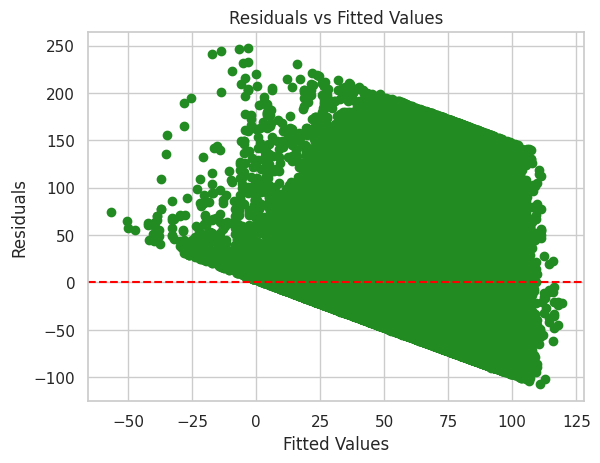

In [ ]:
# Plotting the residuals
plt.scatter(model_fitted.fittedvalues,model_fitted.resid, color = 'forestgreen')
plt.axhline(y=0,color='red',linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

Definitely, the homoskedasticity assumption is violated, because the plot does not show the random scatter around the horizontal line of zero.

Even though we know that the OLS model is not the best model here, we can, for the sake of learning, apply Linear Regression model using scikit-learn.

# Linear Regression model using sklearn

In [ ]:
# Initializing the StandardScaler to scale our independant variables

scaler = StandardScaler()

# Fitting the scaler on the training data and transforming it

X_train_scaled = scaler.fit_transform(X_train)

# Applying the same transformation to the test data
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Creating and fitting the model
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

# Making predictions on the scaled test data
y_pred = lr.predict(X_test_scaled)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)

# Output the performance metrics
print(f"MSE on Test Set: {mse}")
print(f"RMSE on Test Set: {rmse}")

MSE on Test Set: 3087.6203722090627
RMSE on Test Set: 55.566360077020185


Here, the Root Mean Squared Error is huge, so this is just a confirmation that the Linear Regression model is a wrong choice for predicting PM2.5 levels in Beijing. It is equal to: MSE on Test Set: 3080.92 and
RMSE on Test Set: 55.51.

# Regression using a Neural Net

In [ ]:
# Defining feature (independant variable) and target (dependant variable)
# This time I will use a Linear Regression using one feature, not Multiple Linear Regression like I did before

features = ['TEMP']
target = ['PM2.5']

X = data[features]
y = data[target]

In [ ]:
# For the sake of simplicity I will not use the validation dataset

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1111)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 313989 samples
Test set size: 78498 samples


In [ ]:
# Before using this model I need to create a normalization layer using Tensorflow.

temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(X_train)

In [ ]:
# One single node means here that this is linear. Since no activation function is specified,
# it uses a linear activation by default and the output is also linear.

temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [ ]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss='mean_squared_error')

In [ ]:
# By setting a verbose = 1, we are able to see the progress of going through epochs (for 100 epochs it takes a lot of time)
# and we can see the loss for each epoch.

history = temp_nn_model.fit(
    X_train,y_train,
    verbose=1,
    epochs=100
)

Epoch 1/100
9813/9813 [==============================] - 16s 2ms/step - loss: 3508.4658
Epoch 2/100
9813/9813 [==============================] - 17s 2ms/step - loss: 3375.3823
Epoch 3/100
9813/9813 [==============================] - 17s 2ms/step - loss: 3375.0076
Epoch 4/100
9813/9813 [==============================] - 17s 2ms/step - loss: 3375.3389
Epoch 5/100
9813/9813 [==============================] - 16s 2ms/step - loss: 3375.1692
Epoch 6/100
9813/9813 [==============================] - 26s 3ms/step - loss: 3375.3169
Epoch 7/100
9813/9813 [==============================] - 33s 3ms/step - loss: 3375.5049
Epoch 8/100
9813/9813 [==============================] - 16s 2ms/step - loss: 3375.5806
Epoch 9/100
9813/9813 [==============================] - 16s 2ms/step - loss: 3375.3564
Epoch 10/100
9813/9813 [==============================] - 16s 2ms/step - loss: 3375.3889
Epoch 11/100
9813/9813 [==============================] - 18s 2ms/step - loss: 3375.1648
Epoch 12/100
9813/9813 [======

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'],label = 'loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

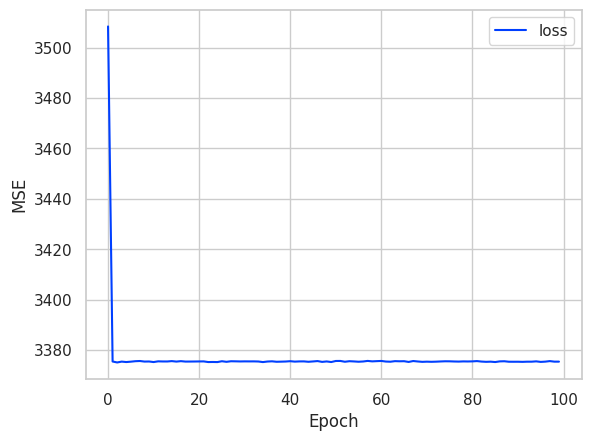

In [ ]:
plot_loss(history)

4/4 [==============================] - 0s 4ms/step


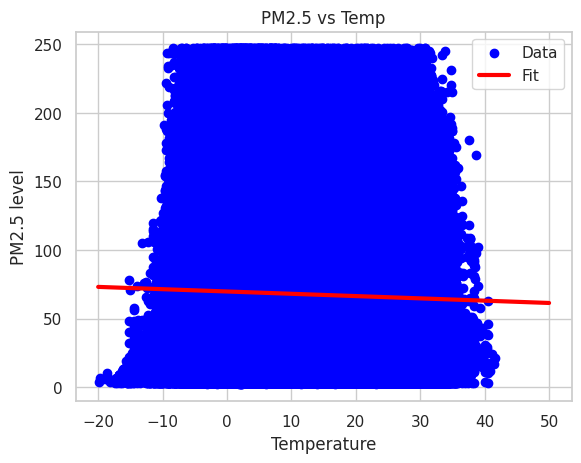

In [ ]:
plt.scatter(X_train, y_train, label ="Data",color="blue")
x = tf.linspace(-20,50,100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)),label="Fit",color="red",linewidth=3)
plt.legend()
plt.title("PM2.5 vs Temp")
plt.ylabel("PM2.5 level")
plt.xlabel("Temperature")
plt.show()


We can see that the line of best fit also is linear, it is a linear regressor but created using a neural net.

In [ ]:
# To evaluate the performance of this model, we can calculate the MSE and RMSE and compare it with our previous results.

# Making predictions on the test data
y_pred = temp_nn_model.predict(X_test)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)

# Output the performance metrics
print(f"MSE on Test Set: {mse}")
print(f"RMSE on Test Set: {rmse}")

2454/2454 [==============================] - 3s 1ms/step
MSE on Test Set: 3391.601871807345
RMSE on Test Set: 58.237461069378234


We can see that the MSE and RMSE are even bigger than in case of Linear Regression model using sklearn. For Linear Regression model using sklearn the values were equal to: MSE on Test Set: 3080.92 and RMSE on Test Set: 55.51, whereas here they are equal to MSE on Test Set: 3376.79 and RMSE on Test Set: 58.11.

# Neural Net

In [ ]:
# I already have a normalizer, so I start building a model.
# I chose 'relu' as an activation function because I can't have smaller PM2.5 level than 0.
#

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1,  activation = 'relu')
])

In [ ]:
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [ ]:
history = nn_model.fit(
    X_train, y_train,
    verbose = 1,
    epochs=100
)

Epoch 1/100
9813/9813 [==============================] - 22s 2ms/step - loss: 3438.4568
Epoch 2/100
9813/9813 [==============================] - 19s 2ms/step - loss: 3369.2695
Epoch 3/100
9813/9813 [==============================] - 20s 2ms/step - loss: 3363.7893
Epoch 4/100
9813/9813 [==============================] - 20s 2ms/step - loss: 3360.6016
Epoch 5/100
9813/9813 [==============================] - 19s 2ms/step - loss: 3359.6357
Epoch 6/100
9813/9813 [==============================] - 20s 2ms/step - loss: 3358.6016
Epoch 7/100
9813/9813 [==============================] - 18s 2ms/step - loss: 3358.2886
Epoch 8/100
9813/9813 [==============================] - 20s 2ms/step - loss: 3358.6709
Epoch 9/100
9813/9813 [==============================] - 19s 2ms/step - loss: 3358.2229
Epoch 10/100
9813/9813 [==============================] - 18s 2ms/step - loss: 3357.9790
Epoch 11/100
9813/9813 [==============================] - 20s 2ms/step - loss: 3357.9336
Epoch 12/100
9813/9813 [======

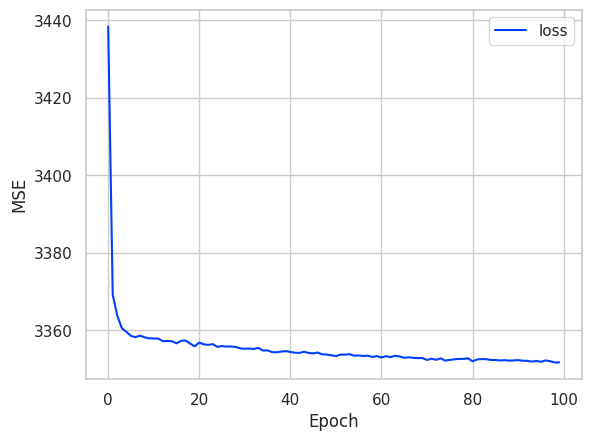

In [ ]:
plot_loss(history)

4/4 [==============================] - 0s 6ms/step


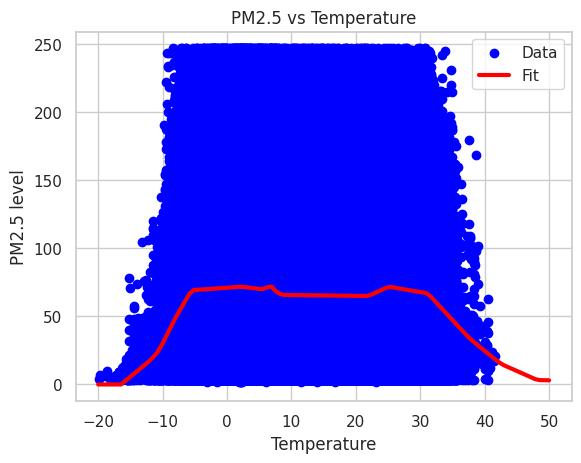

In [ ]:
plt.scatter(X_train, y_train, label ="Data",color="blue")
x = tf.linspace(-20,50,100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)),label="Fit",color="red",linewidth=3)
plt.legend()
plt.title("PM2.5 vs Temperature")
plt.ylabel("PM2.5 level")
plt.xlabel("Temperature")
plt.show()

As we can see, the line of best fit is not linear anymore.

In [ ]:
# To evaluate the performance of this model, we can calculate the MSE and RMSE and compare it with our previous results.

# Making predictions on the test data
y_pred = nn_model.predict(X_test)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)

# Output the performance metrics
print(f"MSE on Test Set: {mse}")
print(f"RMSE on Test Set: {rmse}")

2454/2454 [==============================] - 3s 1ms/step
MSE on Test Set: 3367.9454567826547
RMSE on Test Set: 58.03400259143474


As we can see, here the MSE and RMSE are slightly smaller than MSE and RMSE for Linear Regression using Neural Net. But the difference is small. For Linear Regression using Neural Net MSE on Test Set: 3376.79 and RMSE on Test Set: 58.11. Neural Net with one independant variable (temperature) has MSE equal to 3351.63 and RMSE equal to 57.90. Now I will try Neural Network using multiple inputs.

# Neural Network for multiple inputs

In [ ]:
# Defining features (independant variables) and target (dependant variable)

features = ['TEMP','PRES','RAIN','WSPM']
target = ['PM2.5']

X = data[features]
y = data[target]

In [ ]:
# For the sake of simplicity I will not use the validation dataset

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1111)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 313989 samples
Test set size: 78498 samples


In [ ]:
# Creating normalizer for four features

all_normalizer = tf.keras.layers.Normalization(input_shape=(4,),axis=-1)
all_normalizer.adapt(X_train)

In [ ]:
# I chose 'relu' as an activation function because I can't have smaller PM2.5 level than 0.
# I put the same number of layers and nodes to build a model comparable to the previous one for single input.

nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1,  activation = 'relu')
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [ ]:
history = nn_model.fit(
    X_train, y_train,
    verbose = 1,
    epochs=100
)

Epoch 1/100
9813/9813 [==============================] - 20s 2ms/step - loss: 3000.2000
Epoch 2/100
9813/9813 [==============================] - 22s 2ms/step - loss: 2900.4998
Epoch 3/100
9813/9813 [==============================] - 20s 2ms/step - loss: 2889.7949
Epoch 4/100
9813/9813 [==============================] - 22s 2ms/step - loss: 2885.4331
Epoch 5/100
9813/9813 [==============================] - 20s 2ms/step - loss: 2882.2141
Epoch 6/100
9813/9813 [==============================] - 20s 2ms/step - loss: 2879.3604
Epoch 7/100
9813/9813 [==============================] - 19s 2ms/step - loss: 2876.2874
Epoch 8/100
9813/9813 [==============================] - 21s 2ms/step - loss: 2874.6265
Epoch 9/100
9813/9813 [==============================] - 20s 2ms/step - loss: 2872.2163
Epoch 10/100
9813/9813 [==============================] - 20s 2ms/step - loss: 2870.0994
Epoch 11/100
9813/9813 [==============================] - 21s 2ms/step - loss: 2867.4866
Epoch 12/100
9813/9813 [======

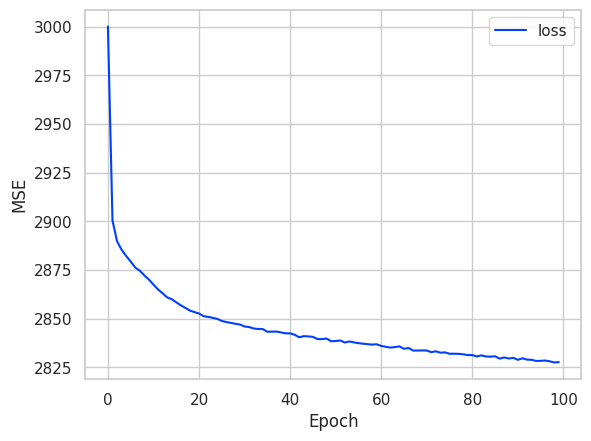

In [ ]:
plot_loss(history)

In [ ]:
# To evaluate the performance of this model, we can calculate the MSE and RMSE and compare it with our previous results.

# Making predictions on the test data
y_pred_nn = nn_model.predict(X_test)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred_nn)
rmse = sqrt(mse)

# Output the performance metrics
print(f"MSE on Test Set: {mse}")
print(f"RMSE on Test Set: {rmse}")

2454/2454 [==============================] - 3s 1ms/step
MSE on Test Set: 2850.9479837800045
RMSE on Test Set: 53.3942692035391


This is definitely the best MSE and RMSE value so far! But it is still not great. Let's continue looking for a model giving even better predictions.

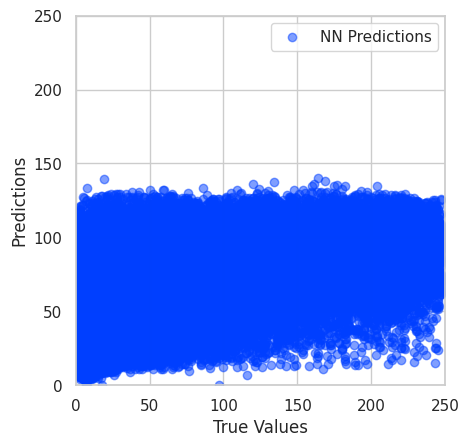

In [ ]:
ax = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred_nn, label = 'NN Predictions', alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predictions")
limits = [0,250]
plt.xlim(limits)
plt.ylim(limits)
plt.legend()

It is worth mentioning that true values range to 250 whereas predictions are ranging from zero to about 160 micrograms/m3.